<h1> ADS 509 Module 3: Group Comparison </h1>

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpu
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


# Notebook Setup

In [1]:
# in alphabetical order
import emoji
import pandas as pd
import os
import re

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [2]:
# Use this space for any additional import statements you need
import string

from IPython.display import  display

In [3]:
# Some punctuation variations
punctuation = set(string.punctuation) # speeds up comparison
punctuation.add('•')
punctuation.remove('#')
tw_punct = punctuation.copy()

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# Custom FNs
All Functions are in alphabetical Order

In [4]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)


def descriptive_stats(tokens, top_tokens=False, num_top_tokens = 5, verbose=False) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens,
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity),
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters.
    """
    def character_counter(text):
        total_chars = 0
        for word in text:
            total_chars += len(word)
        return total_chars

    # Fill in the correct values here.
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens
    num_characters = character_counter(tokens)

    if verbose:
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

    # print the five most common tokens
    if top_tokens:
        most_common = Counter(tokens).most_common(num_top_tokens)
        keys = [x[0] for x in most_common]
        values = [x[1] for x in most_common]

        print('**'*12, '\n', f'-----TOP {num_top_tokens} TOKENS-----')
        print(pd.DataFrame({'keys':keys, 'values':values}))

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

def desc_stats_2_DF(stats, stats_of):
    df = pd.DataFrame({'stats_of':[stats_of],
                       'num_tokens':[stats[0]],
                       'num_unique_tokens':[stats[1]],
                       'lexical_diversity':[stats[2]],
                       'num_characters':[stats[3]]})
    return df

def contains_emoji(s):
    emoji_count = emoji.emoji_count(s)
    return(emoji_count > 0)

def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)

def remove_stop(tokens) :
    tokens = [token for token in tokens if token not in sw]
    return(tokens)

def remove_punctuation(text, punct_set=tw_punct):
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) :
    """ Splitting on whitespace rather than the book's tokenize function. That
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """

    tokens = text.split()
    return(tokens)

from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                   if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


# Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

## Twitter Data

In [5]:
data_location = "/Volumes/GoogleDrive/My Drive/_509/my_M1_data/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'ffdp':'FFDP_followers_data.txt',
                'rezz':'OfficialRezz_followers_data.txt'}

ffdp_twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['ffdp'],
                                sep="\t",
                                engine='python')

rezz_twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['rezz'],
                                sep="\t",
                                engine='python')

to_concat = [ffdp_twitter_data,rezz_twitter_data]
twitter_data = pd.concat(to_concat).reset_index(drop=True)

del(to_concat)

### Removal of Descriptions with NaN

There are some NaNs in the descriptions, which would deem fruitless for this homework assignment, thus rows with NaN values are removed.

In [6]:
twitter_data.isnull().mean() * 100

Artist              0.000000
Id                  0.000500
Name                0.046500
User_Name           0.002500
Description        33.642336
Location           54.904549
Followers_Count     0.005000
dtype: float64

We don't need location data for text analysis.

In [7]:
# grab only needed columns
twitter_data = twitter_data[['Artist', 'User_Name', 'Description']]

b4 = twitter_data.shape[0]
# drop na rows
twitter_data = twitter_data.dropna().reset_index(drop=True)
after = twitter_data.shape[0]
print(f'We dropped a total of {b4-after:,} rows,',
      f'leaving us with {after:,} rows.')

We dropped a total of 67,284 rows, leaving us with 132,714 rows.


## Lyrics Data

In [8]:
path_ = data_location + lyrics_folder + 'FFDP/FFDP_song_lyrics_df.csv'
ffdp_lyrics = pd.read_csv(path_)

path_ = data_location + lyrics_folder + 'OfficialRezz/OfficialRezz_song_lyrics_df.csv'
rezz_lyrics = pd.read_csv(path_)

to_concat = [ffdp_lyrics,rezz_lyrics]
lyrics_data = pd.concat(to_concat).reset_index(drop=True)

del(to_concat)

# Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove punctuation
* Split on whitespace
* Remove stopwords (optional)

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove punctuation other than emojis or hashtags
* Split on whitespace
* Remove stopwords

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those.

NOTE: Song Titles are in their own independent column, seperated from lyrics as shown in the following cell.

In [9]:
lyrics_data.head(2)

,Artist,Title,Lyrics
0,FFDP,Ashes,"Right Hate, hate, hate! Bring it! You don'..."
1,FFDP,The_Way_Of_The_Fist,"Break this shit down! Zoltan, open the sky!..."


## Pipelines

#### Twitter Pipeline

In [10]:
my_pipeline = [str.lower, remove_punctuation, tokenize]

lyrics_data["tokens"] = lyrics_data["Lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

#### Lyrics Pipeline

In [11]:
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

twitter_data["tokens"] = twitter_data["Description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)

## Emoji Exploration
Let's take a quick look at some descriptions with emojis.

In [12]:
twitter_data['has_emoji'] = twitter_data["Description"].apply(contains_emoji)

cols = ["Artist","Description","tokens"]
twitter_data[twitter_data.has_emoji].sample(n=5,random_state=1)[cols]

,Artist,Description,tokens
7215,FFDP,Rangers FC till I die 💙 Formula 1 forever #LH...,"[rangers, fc, till, die, 💙, formula, 1, foreve..."
31533,FFDP,I LOVE MEN 😳,"[love, men, 😳]"
8089,FFDP,"Cosplayer, Bouncer, Metal-head 🤘🤘 & Goofball.\...","[cosplayer, bouncer, metalhead, 🤘🤘, goofball, ..."
111388,OfficialRezz,welcome 😁👌,"[welcome, 😁👌]"
35891,FFDP,Always remember us this way ❤️🎶🎵,"[always, remember, us, way, ❤️🎶🎵]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A:  Tokenizing/seperating individual emoticons would be the next step.  Currently, sequential emotiecons are clumped together (as shown below).

In [13]:
twitter_data.loc[27763,['Description','tokens']]

Description      🖤🤘🏼🎸
tokens         [🖤🤘🏼🎸]
Name: 27763, dtype: object

# Song Descriptive Statistics
Calculate descriptive statistics on the two sets of lyrics and compare the results.


## FFDP Stats

In [14]:
# select artist based on regex bool
artist = 'FFDP'
pattern = f'.*{artist}.*'
artist_bool = lyrics_data.Artist.str.contains(pattern)
# regex pattern for song
pattern = r'^Death.*'
pattern_bool = lyrics_data.Title.str.contains(pattern)
ffdp_song = lyrics_data[pattern_bool & artist_bool]
ffdp_song[['Artist','Title']]

,Artist,Title
8,FFDP,Death_Before_Dishonor


In [15]:
ffdp_stats = descriptive_stats(ffdp_song['tokens'].to_list()[0],top_tokens=True, verbose=True)
ffdp_stats = desc_stats_2_DF(ffdp_stats,stats_of='FFDP')
ffdp_stats

There are 206 tokens in the data.
There are 101 unique tokens in the data.
There are 830 characters in the data.
The lexical diversity is 0.490 in the data.
************************ 
 -----TOP 5 TOKENS-----
   keys  values
0   you      14
1   the      11
2    me       9
3  bury       8
4   and       6


,stats_of,num_tokens,num_unique_tokens,lexical_diversity,num_characters
0,FFDP,206,101,0.490291,830


## Rezz Stats

In [16]:
# select artist based on regex bool
artist = 'Rezz'
pattern = f'.*{artist}.*'
artist_bool = lyrics_data.Artist.str.contains(pattern)

# regex pattern for song
pattern = r'.*Lost.*'
pattern_bool = lyrics_data.Title.str.contains(pattern)
rezz_song = lyrics_data[artist_bool & pattern_bool]
rezz_song[['Artist','Title']]

,Artist,Title
20,OfficialRezz,Lost


In [17]:
rezz_stats = descriptive_stats(rezz_song['tokens'].to_list()[0],top_tokens=True, verbose=True)
rezz_stats = desc_stats_2_DF(rezz_stats,stats_of='Rezz')
rezz_stats

There are 314 tokens in the data.
There are 84 unique tokens in the data.
There are 1016 characters in the data.
The lexical diversity is 0.268 in the data.
************************ 
 -----TOP 5 TOKENS-----
   keys  values
0     i      36
1    am      32
2  lost      31
3    me      29
4   you      19


,stats_of,num_tokens,num_unique_tokens,lexical_diversity,num_characters
0,Rezz,314,84,0.267516,1016


## Lyrics Comparison Chart

In [18]:
pd.concat([ffdp_stats, rezz_stats])

,stats_of,num_tokens,num_unique_tokens,lexical_diversity,num_characters
0,FFDP,206,101,0.490291,830
0,Rezz,314,84,0.267516,1016


Q: what observations do you make about these data?

A: I expected a majority of FFDP lyrics to be greater in lexical diversity due to the stereotypical idea the genres of the two artist represent.
* FFDP == Metal, Groove Metal, Nu Metal, Thrash Metal
* Rezz == New Beat Techno, Mid-tempo EDM, Eletronic

The above comparison chart of single songs from each artist proves my idea; though it would be interesting to get stats on all songs for both artist and see the range of stats.


# Corpus Unique Tokens
Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis.

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it.

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing.

In this section find 10 tokens for each of your four corpora that meet the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

## FFDP Corpera Builds

In [19]:
ffdp_lyrics_freq_df = lyrics_data.loc[lyrics_data['Artist'] == 'FFDP']
ffdp_lyrics_freq_df = count_words(ffdp_lyrics_freq_df)

ffdp_twitter_freq_df = twitter_data.loc[twitter_data['Artist'] == 'FFDP']
ffdp_twitter_freq_df = count_words(ffdp_twitter_freq_df)

## Rezz Corpera Builds

In [20]:
rezz_lyrics_freq_df = lyrics_data.loc[lyrics_data['Artist'] == 'OfficialRezz']
rezz_lyrics_freq_df = count_words(rezz_lyrics_freq_df)

rezz_twitter_freq_df = twitter_data.loc[twitter_data['Artist'] == 'OfficialRezz']
rezz_twitter_freq_df = count_words(rezz_twitter_freq_df)

## Overarching Corpera Build

In [21]:
cut_off = 3
top_tokens = 10 # find top 10 tokens

corpus_list = [ffdp_lyrics_freq_df,
               ffdp_twitter_freq_df,
               rezz_lyrics_freq_df,
               rezz_twitter_freq_df]
corpera = []

for df in corpus_list:
    # copy df to insure we don't write to original df
    df = df.copy()
    df.reset_index(drop=False, inplace= True)

    df = df[df['freq'] > cut_off]

    corpera.extend(df['token'])

corpera = list(set(corpera))
corpera = pd.DataFrame({'tokens':corpera})
corpera.shape

(14833, 1)

In [22]:
ffdp_twitter_corpus = corpera.merge(
    ffdp_twitter_freq_df[ffdp_twitter_freq_df['freq'] > cut_off],
    left_on='tokens',
    right_index=True,
)

ffdp_corpera_freqs = ffdp_twitter_corpus.merge(
    ffdp_lyrics_freq_df[ffdp_lyrics_freq_df['freq'] > cut_off],
    left_on='tokens',
    right_index=True,
    suffixes=('_ffdp_twi','_ffdp_lyr')
)
ffdp_corpera_freqs.shape

(163, 3)

In [23]:
rezz_twitter_corpus = corpera.merge(
    rezz_twitter_freq_df[rezz_twitter_freq_df['freq'] > cut_off],
    left_on='tokens',
    right_index=True,
)

rezz_corpera_freqs = rezz_twitter_corpus.merge(
    rezz_lyrics_freq_df[rezz_lyrics_freq_df['freq'] > cut_off],
    left_on='tokens',
    right_index=True,
    suffixes=('_rezz_twi','_rezz_lyr')
)
rezz_corpera_freqs.shape

(89, 3)

In [24]:
# merge the two corpera frequency dfs
corpera = ffdp_corpera_freqs.merge(
    rezz_corpera_freqs,
    left_on='tokens',
    right_on='tokens')

corpera = corpera.set_index('tokens')

print(corpera.shape)
corpera.head(2)

(38, 4)


,freq_ffdp_twi,freq_ffdp_lyr,freq_rezz_twi,freq_rezz_lyr
tokens,,,,
ill,197,23,139,8
days,101,4,92,4


In [25]:
token_totals = corpera.apply(sum,axis=1)
token_totals = token_totals.reset_index()
token_totals = token_totals.rename(columns={0:'sum'})
token_totals.head(2)

,tokens,sum
0,ill,367
1,days,201


In [26]:
row_count, col_count = corpera.shape

ratio_data = {}
for col in range(0,col_count):

    ratios = []
    for row in range(0,row_count):
        corpus_count = corpera.iloc[row,col]
        ratio =  corpus_count / token_totals.loc[row,'sum']
        ratios.append(ratio)

    col_name = corpera.columns[col]
    ratio_data[f'{col_name}_ratios'] = ratios

ratio_df = pd.DataFrame(ratio_data)
ratio_df.head(2)

,freq_ffdp_twi_ratios,freq_ffdp_lyr_ratios,freq_rezz_twi_ratios,freq_rezz_lyr_ratios
0,0.536785,0.06267,0.378747,0.021798
1,0.502488,0.01990,0.457711,0.019900


In [27]:
corpera_top_tokens_df = token_totals.merge(ratio_df,
                                        left_index=True,
                                        right_index=True)

corpera_top_tokens_df.head(2)

,tokens,sum,freq_ffdp_twi_ratios,freq_ffdp_lyr_ratios,freq_rezz_twi_ratios,freq_rezz_lyr_ratios
0,ill,367,0.536785,0.06267,0.378747,0.021798
1,days,201,0.502488,0.01990,0.457711,0.019900


In [28]:
# grab columns with frequency ratios
ratio_columns = [col for col in corpera_top_tokens_df.columns if col[:3] == 'fre']

for col in ratio_columns:
    # grab top 10 words for that corpus
    wanted_cols = ['tokens', col]
    df = corpera_top_tokens_df.sort_values(col,ascending=False)
    display(df[wanted_cols].head(10))

,tokens,freq_ffdp_twi_ratios
22,im,0.668007
32,love,0.649436
26,death,0.614362
27,dont,0.584960
6,wont,0.557692
36,say,0.556886
4,life,0.556761
21,die,0.545031
8,way,0.541176
29,heart,0.538103


,tokens,freq_ffdp_lyr_ratios
3,enough,0.156118
20,supposed,0.142857
16,cant,0.109181
6,wont,0.102564
7,apart,0.094340
25,youre,0.078873
0,ill,0.062670
2,cause,0.061856
30,never,0.048270
31,id,0.045752


,tokens,freq_rezz_twi_ratios
15,place,0.563863
13,wanna,0.530271
35,eyes,0.510638
12,let,0.507187
37,world,0.504315
17,time,0.500434
11,get,0.488599
10,go,0.478491
9,see,0.477876
19,take,0.473475


,tokens,freq_rezz_lyr_ratios
20,supposed,0.190476
24,taste,0.140000
6,wont,0.076923
7,apart,0.075472
2,cause,0.061856
26,death,0.055851
31,id,0.052288
19,take,0.050398
25,youre,0.045070
14,mine,0.042328


Q: What are some observations about the top tokens? Do you notice any interesting items on the list?

A:

# Word Clouds
Build word clouds for all four corpora.

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book.

-----------------
------------
NOTE!!! count_words FN was moved to "Custom FNs" section, due to the fact that the FN was utilized in the section above "Corpus Unique Tokens"


In [29]:
'''
stopwords are used again on twitter data, due to the extension above to remove
popular determiners "i'm" and "im"
'''
sw.extend(["i'm", "i’m", "i`m", "im"])

## FFDP WordClouds

### Twitter WordClouds

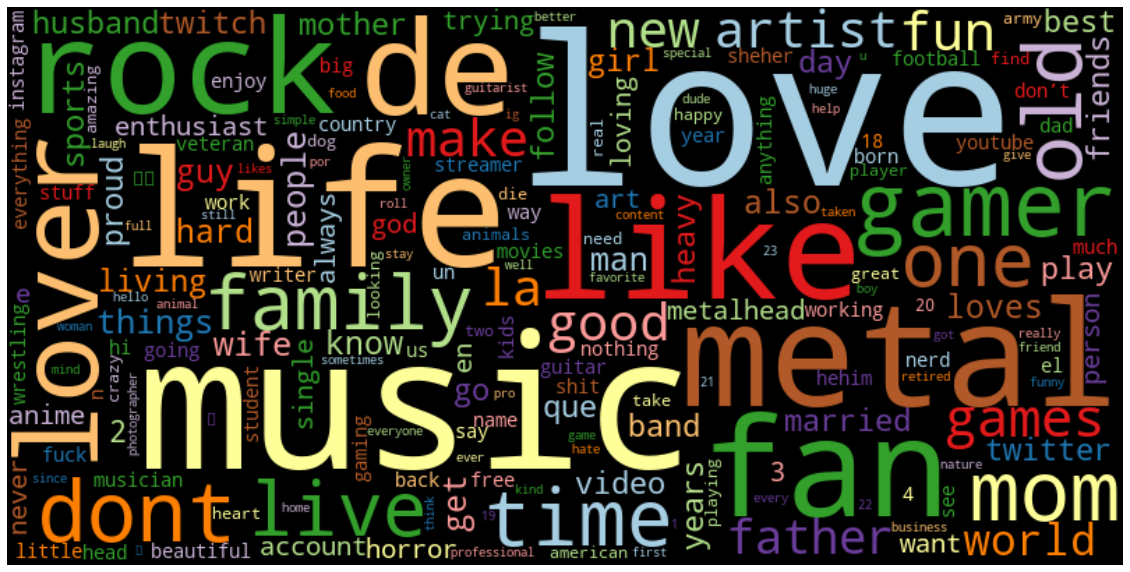

In [30]:
ffdp_twitter_freq_df = twitter_data.loc[twitter_data['Artist'] == 'FFDP']
ffdp_twitter_freq_df = count_words(ffdp_twitter_freq_df)
plt.figure(figsize=(20,20))
wordcloud(ffdp_twitter_freq_df['freq'], stopwords=sw)

### Lyrics Word Clouds

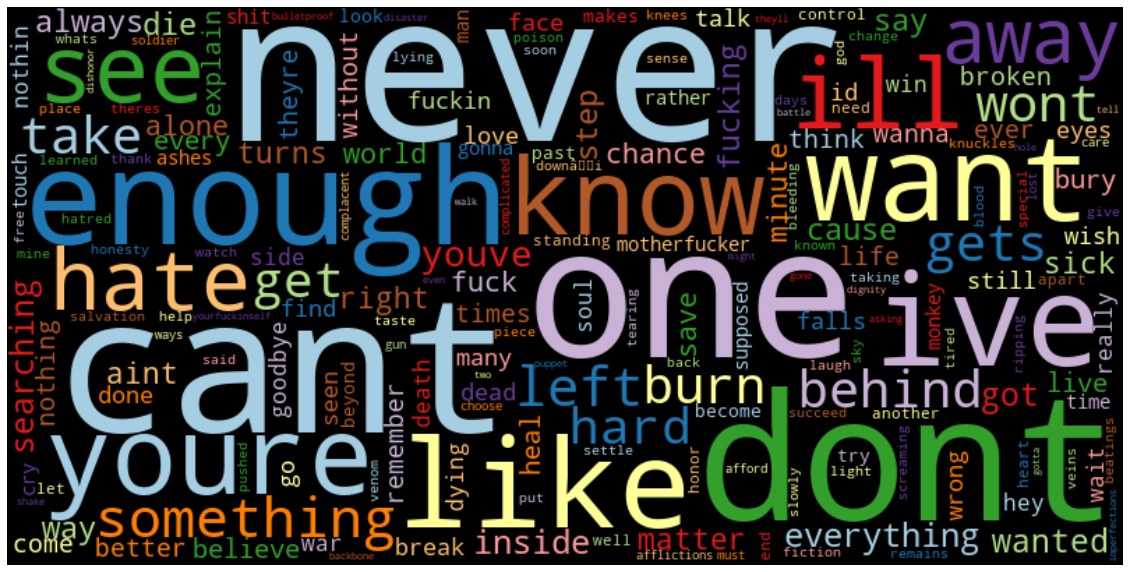

In [31]:
plt.figure(figsize=(20,20))
wordcloud(ffdp_lyrics_freq_df['freq'], stopwords=sw)

## Rezz Word Clouds

### Twitter Word Clouds

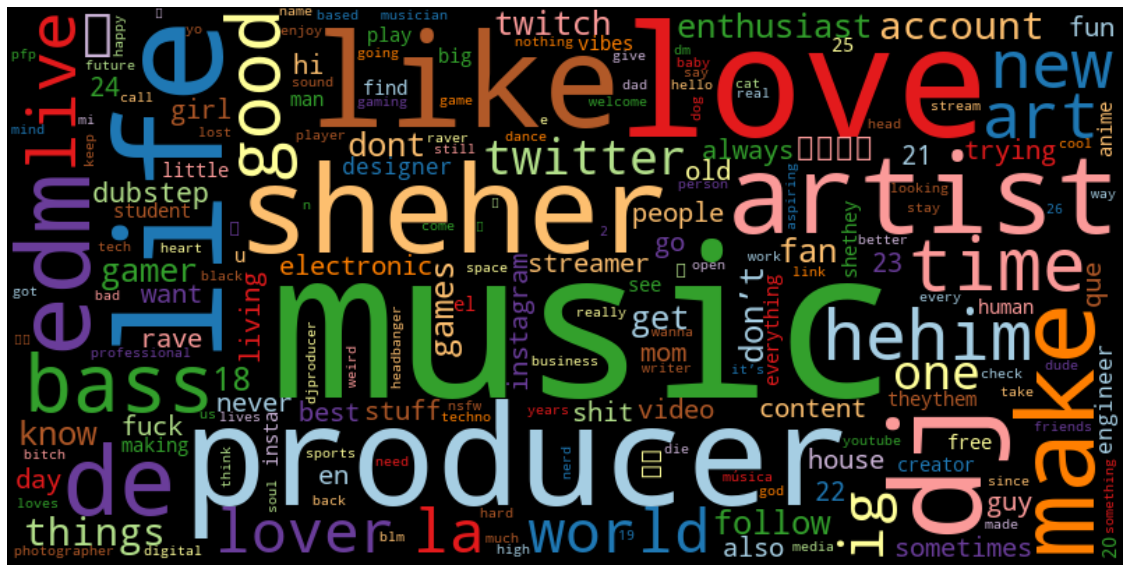

In [32]:
plt.figure(figsize=(20,20))
wordcloud(rezz_twitter_freq_df['freq'], stopwords=sw)

### Lyrics Word Clouds

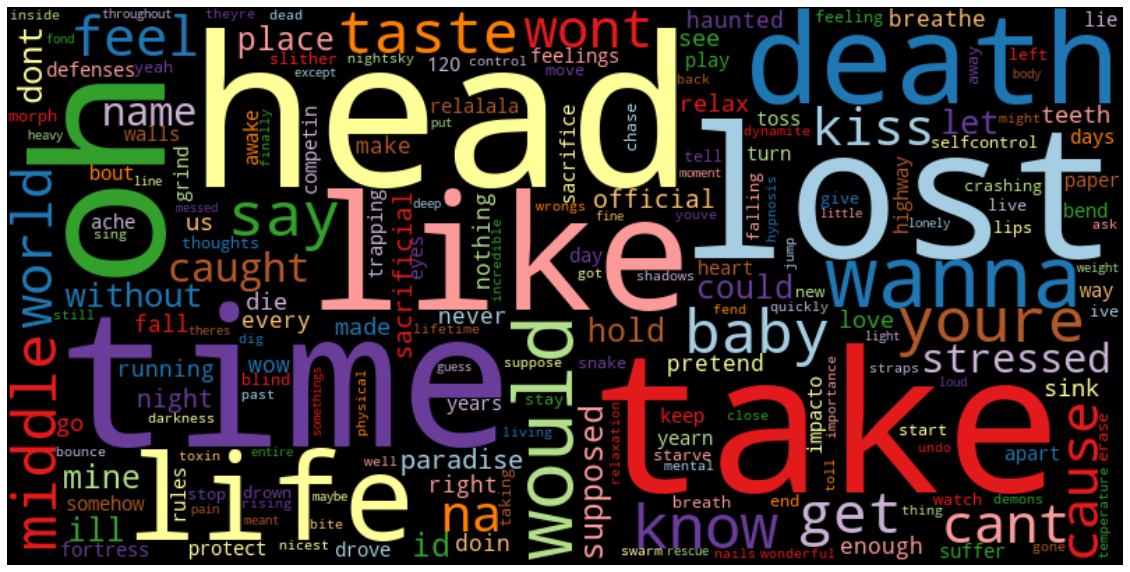

In [34]:
plt.figure(figsize=(20,20))
wordcloud(rezz_lyrics_freq_df['freq'], stopwords=sw)

## All Word Clouds Comparison

In [38]:
def word_cloud_compare(twitter_df, lyrics_df):
    plt.figure(figsize=(26,26))
    plt.subplot(221)
    wordcloud(twitter_df['freq'], stopwords=sw)
    plt.subplot(222)
    wordcloud(lyrics_df['freq'], stopwords=sw)

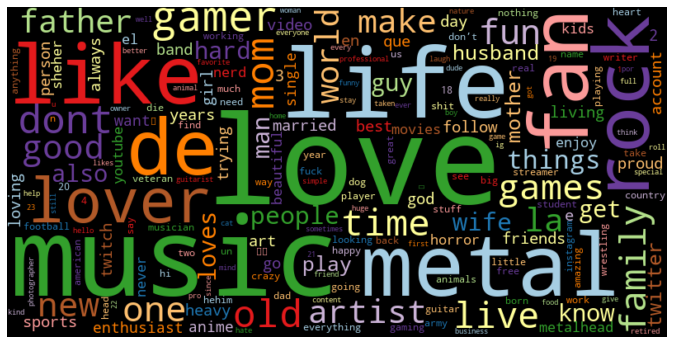

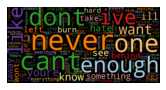

In [39]:
word_cloud_compare(ffdp_twitter_freq_df, ffdp_lyrics_freq_df)

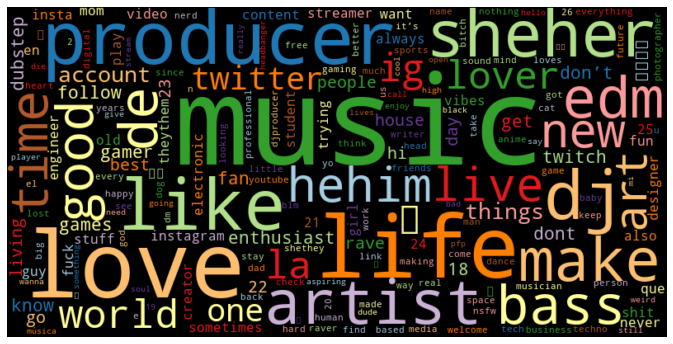

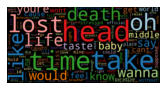

In [40]:
word_cloud_compare(rezz_twitter_freq_df, rezz_lyrics_freq_df)

Q: What observations do you have about these (relatively straightforward) wordclouds? 

Interesting to see the Twitter Clouds for both artists have love, life, music, and lover.  What seperates the two Twitter clouds is fans of FFDP appear to be an older crowd with words such as the following:
 * man
 * mom
 * mother
 * wife
 * husband
 * father
 * guy

While fans of Rezz appear to be a younger crowd utilizing words such as:
* she/her
* he/him
* 18
* 21
* instagram
* twitch